# **DEPENDENCIES**

In [73]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

In [ ]:
from google.colab import drive; drive.mount("/content/drive")

# **DATASET**

In [69]:
def create_dataset(faces_dataset_path):
    train_images = []
    train_labels = []
    val_images = []
    val_labels = []
    test_images = []
    test_labels = []

    class_labels = os.listdir(faces_dataset_path)
    num_classes = len(class_labels)

    for class_idx, folder in enumerate(tqdm(class_labels)):
        folder_path = os.path.join(faces_dataset_path, folder)
        images = os.listdir(folder_path)
        num_images = len(images)

        for i, file in enumerate(images):
            img = cv2.imread(os.path.join(folder_path, file))
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if i < 0.7 * num_images:
                train_images.append(img)
                train_labels.append(class_idx)
            elif i < 0.85 * num_images:
                val_images.append(img)
                val_labels.append(class_idx)
                test_images.append(img)
                test_labels.append(class_idx)

    return (
        np.array(train_images), np.array(train_labels),
        np.array(val_images), np.array(val_labels),
        np.array(test_images), np.array(test_labels)
    )

### **Faces Dataset**   
Description: 9 different people. 128 x 128 images

In [122]:
faces_dataset_path = "/content/drive/MyDrive/data_assn2_cv/actors/faces"
Xtrf, Ytrf, Xvaf, Yvaf, Xtef, Ytef = create_dataset(faces_dataset_path)

100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


### **Cifar10 Dataset**  
Description:
1. Using Cifar10 for non-human objects. These images are 32 x 32, but it won't be a problem since the histograms will be normalized.
2. For grayscaling, I use the formula $Gr = 0.3R + 0.59G + 0.11B$ as per the following blog (Did this to avoid using cv2 loops):  
[Colour to Grayscale](https://www.baeldung.com/cs/convert-rgb-to-grayscale)

In [83]:
(Xtrc, Ytrc), (Xtec, Ytec) = tf.keras.datasets.cifar10.load_data()
Xtrc = np.dot(Xtrc, [0.3, 0.59, 0.11]).astype(int)
Xtec = np.dot(Xtec, [0.3, 0.59, 0.11]).astype(int)

# **HLBP**  
### Local Binary Pattern (LBP) Computation

The `compute_lbp` function takes an input grayscale image, `radius`, and `npoints`. It calculates LBP values for each pixel, encoding local texture patterns based on comparisons with neighboring pixels. The output is an LBP image.

### Formula

For each pixel (i, j):

- `center` is the intensity value of the center pixel.
- `x_offsets` and `y_offsets` represent sample point positions relative to the center.
- `pattern` is a binary pattern encoding relationships between the center and its neighbors.
- LBP value is stored in the output LBP image at (i, j).


In [134]:
def compute_lbp(images, radius=1, npoints=8, axis=0):
    if axis not in [0, 1]:
        raise ValueError(
            "Axis must be 0 or 1 for row-wise or column-wise processing."
        )

    num_images, height, width = images.shape
    lbp_images = np.zeros(images.shape, dtype=np.uint8)

    angles = np.linspace(0, 2 * np.pi, npoints, endpoint=False)
    x_offsets = np.round(radius * np.cos(angles)).astype(int)
    y_offsets = np.round(radius * np.sin(angles)).astype(int)

    for i in range(radius, height - radius):
        for j in range(radius, width - radius):
            center = images[:, i, j] if axis == 0 else images[i, j, :]
            pattern = np.zeros(num_images, dtype=np.uint8)
            for x_offset, y_offset in zip(x_offsets, y_offsets):
                x = i + x_offset
                y = j + y_offset
                neighbor = images[:, x, y] if axis == 0 else images[x, y, :]
                pattern = (pattern << 1) | (neighbor >= center)
            lbp_images[:, i, j] = pattern

    return lbp_images

In [126]:
def plot_lbp(original_images, lbp_images):
    num_images = len(original_images)
    fig, axs = plt.subplots(2, num_images, figsize=(3 * num_images, 6))
    plt.tight_layout(pad=0.0)
    for i in range(num_images):
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')

        axs[1, i].imshow(lbp_images[i], cmap='gray')
        axs[1, i].set_title('LBP')
        axs[1, i].axis('off')
    plt.show()

### Plot of Original vs LBP images

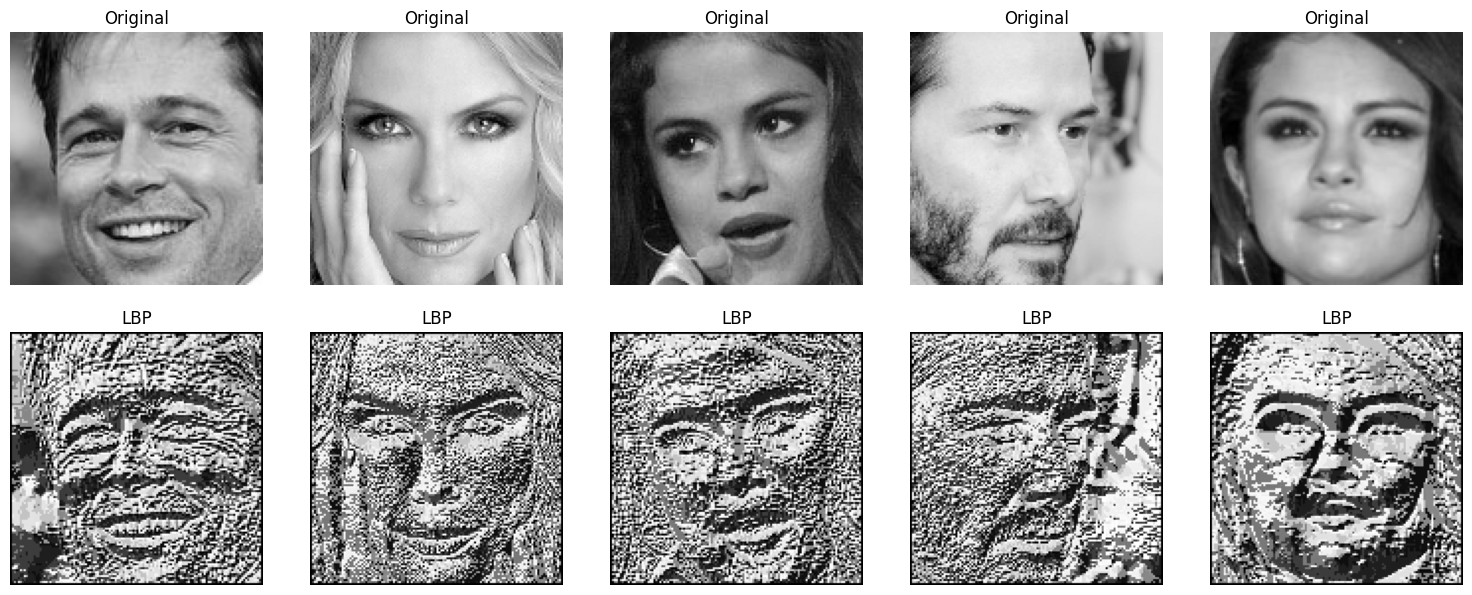

In [145]:
S = Xtrf[np.random.randint(0, Xtrf.shape[0], 5)]; plot_lbp(S, compute_lbp(S))

### Compute Histograms of LBP

In [161]:
def compute_hist(images):
    images = images.reshape(images.shape[0], -1)
    bins = np.arange(-0.5, 255.5, 1)
    hist = np.apply_along_axis(
        lambda x: np.histogram(x, bins=bins)[0], 1, images
    ).astype('float')
    hist /= np.linalg.norm(hist, axis=1, keepdims=True)
    return hist